In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score, auc, precision_recall_curve, roc_curve
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization, Activation, Add, SeparableConv2D, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import optuna
from optuna.integration import TFKerasPruningCallback
import csv

# Force GPU usage
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Using GPU:", physical_devices)
else:
    print("No GPU found. Using CPU instead.")

# Data parameters
base_dir = 'C:\\Users\\NickZografos\\Thesis Thanasis\\data_aug_3'
subfolders = ['clear', 'clouds']
categories = ['Healthy_augmented', 'Damaged_augmented']
IMG_HEIGHT =  64
IMG_WIDTH = 64
BATCH_SIZE = 32

# Function to load data
def load_data(base_dir, subfolders, categories, img_height, img_width):
    data = []
    labels = []
    image_paths = []
    for category in categories:
        class_num = categories.index(category)
        for subfolder in subfolders:
            folder_path = os.path.join(base_dir, subfolder, category)
            images = sorted(os.listdir(folder_path))
            for img_name in images:
                if img_name.endswith('.png'):
                    img_path = os.path.join(folder_path, img_name)
                    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
                    img_array = tf.keras.preprocessing.image.img_to_array(img)
                    data.append(img_array)
                    labels.append(class_num)
                    image_paths.append((subfolder, category, img_name))
    return np.array(data), np.array(labels), image_paths

# Load data
data, labels, image_paths = load_data(base_dir, subfolders, categories, IMG_HEIGHT, IMG_WIDTH)
data = data / 255.0  # Normalize the data

# Split data ensuring twins are in the same split
def split_data(image_paths):
    unique_image_ids = list(set([img_name for subfolder, category, img_name in image_paths]))
    train_ids, test_ids = train_test_split(unique_image_ids, test_size=0.2, random_state=42)
    train_ids, val_ids = train_test_split(train_ids, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2
    return train_ids, val_ids, test_ids

def get_split_indices(image_paths, split_ids):
    split_indices = [i for i, (subfolder, category, img_name) in enumerate(image_paths) if img_name in split_ids]
    return split_indices

# Split data into training, validation, and test sets
train_ids, val_ids, test_ids = split_data(image_paths)
train_indices = get_split_indices(image_paths, train_ids)
val_indices = get_split_indices(image_paths, val_ids)
test_indices = get_split_indices(image_paths, test_ids)

X_train, y_train = data[train_indices], labels[train_indices]
X_val, y_val = data[val_indices], labels[val_indices]
X_test, y_test = data[test_indices], labels[test_indices]

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Define true labels for test set (used globally)
y_test_true = np.argmax(y_test, axis=1)

# Create data generator for data augmentation
def create_datagen(seed=None):
    return ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest'
    ), seed

datagen, seed = create_datagen(seed=42)
datagen.fit(X_train)
train_generator = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, seed=seed)
val_generator = datagen.flow(X_val, y_val, batch_size=BATCH_SIZE, seed=seed)

# Compute class weights to handle data imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))

# Define residual block
def residual_block(x, filters, kernel_size, use_batchnorm=True):
    shortcut = x
    x = SeparableConv2D(filters, (kernel_size, kernel_size), padding='same')(x)
    if use_batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(filters, (kernel_size, kernel_size), padding='same')(x)
    if use_batchnorm:
        x = BatchNormalization()(x)
    
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)
        if use_batchnorm:
            shortcut = BatchNormalization()(shortcut)
        
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Define attention block
def attention_block(x, filters):
    attention = MultiHeadAttention(num_heads=8, key_dim=filters)(x, x)
    attention = Add()([x, attention])
    return attention

# Define the model structure
def build_model(trial, use_batchnorm=True):
    num_residual_blocks = trial.suggest_int('num_residual_blocks', 2, 5)
    filters = trial.suggest_int('filters', 32, 128)
    kernel_size = trial.suggest_int('kernel_size', 3, 5)
    dense_units = trial.suggest_int('dense_units', 512, 2048)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    for _ in range(num_residual_blocks):
        x = residual_block(x, filters, kernel_size, use_batchnorm=use_batchnorm)
        x = attention_block(x, filters)
        if x.shape[1] >= 2 and x.shape[2] >= 2:
            x = MaxPooling2D((2, 2))(x)
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(2, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Objective function for Optuna hyperparameter optimization
def objective(trial):
    model = build_model(trial, use_batchnorm=True)  # By default, use batch normalization
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
    
    history = model.fit(
        train_generator,
        steps_per_epoch=len(X_train) // BATCH_SIZE,
        epochs=80,
        validation_data=val_generator,
        class_weight=class_weights,
        callbacks=[early_stopping, reduce_lr, TFKerasPruningCallback(trial, 'val_loss')],
        verbose=1
    )
    
    val_accuracy = np.max(history.history['val_accuracy'])
    return val_accuracy

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=300)

Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


[I 2024-09-24 00:57:06,771] A new study created in memory with name: no-name-17f81540-f214-4c9b-aa27-09285cfb8fdd


In [37]:
len(y_test_true)  # This should match the number of test samples in X_test


2416

In [2]:
best_params = {'num_residual_blocks': 4, 'filters': 121, 'kernel_size': 5, 'dense_units': 1387, 'dropout_rate': 0.40846071442232423, 'learning_rate': 0.0002469909302048313}
best_params

{'num_residual_blocks': 4,
 'filters': 121,
 'kernel_size': 5,
 'dense_units': 1387,
 'dropout_rate': 0.40846071442232423,
 'learning_rate': 0.0002469909302048313}

In [3]:
# Plot and save loss curve for the best model
def plot_best_model_loss(history, model_name='Best Model (Optuna)'):
    plt.plot(history.history['loss'], label=f'{model_name} - Train Loss')
    plt.plot(history.history['val_loss'], label=f'{model_name} - Val Loss')
    plt.title(f'Loss Comparison - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'loss_comparison_{model_name}.png', dpi=450)
    plt.show()


Best parameters found:  {'num_residual_blocks': 4, 'filters': 121, 'kernel_size': 5, 'dense_units': 1387, 'dropout_rate': 0.40846071442232423, 'learning_rate': 0.0002469909302048313}


C:\Users\NickZografos\AppData\Local\Temp\ipykernel_28112\2105037378.py:144: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Epoch 1/200
226/226 [==============================] - 56s 227ms/step - loss: 0.7535 - accuracy: 0.5258 - val_loss: 0.6964 - val_accuracy: 0.4222 - lr: 2.4699e-04
Epoch 2/200
226/226 [==============================] - 51s 226ms/step - loss: 0.6944 - accuracy: 0.5592 - val_loss: 0.6920 - val_accuracy: 0.5596 - lr: 2.4699e-04
Epoch 3/200
226/226 [==============================] - 52s 228ms/step - loss: 0.6795 - accuracy: 0.5723 - val_loss: 0.6837 - val_accuracy: 0.5956 - lr: 2.4699e-04
Epoch 4/200
226/226 [==============================] - 52s 229ms/step - loss: 0.6777 - accuracy: 0.5956 - val_loss: 0.6751 - val_accuracy: 0.5774 - lr: 2.4699e-04
Epoch 5/200
226/226 [==============================] - 52s 230ms/step - loss: 0.6762 - accuracy: 0.5826 - val_loss: 0.6783 - val_accuracy: 0.5728 - lr: 2.4699e-04
Epoch 6/200
226/226 [==============================] - 52s 230ms/step - loss: 0.6742 - accuracy: 0.6019 - val_loss: 0.6779 - val_accuracy: 0.5832 - lr: 2.4699e-04
Epoch 7/200
226/226 [=

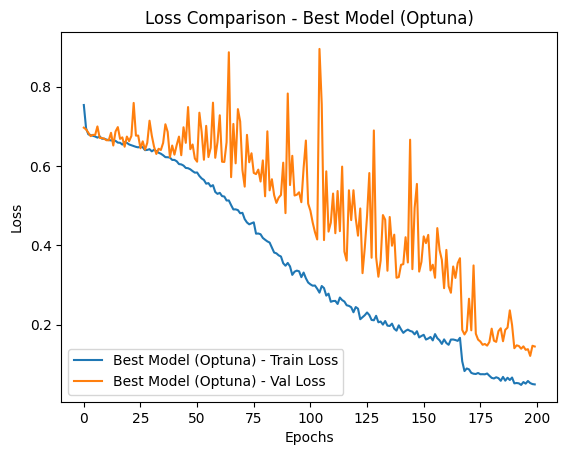

76/76 [==============================] - 7s 86ms/step


In [4]:
# Print the best parameters
#best_params = study.best_params
print("Best parameters found: ", best_params)
#print("Best score: ", study.best_value)

# Build the best model from Optuna's results and fit it to get the history object
best_model = build_model(optuna.trial.FixedTrial(best_params))

# Train the best model on the full dataset
history = best_model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=200, #250
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[EarlyStopping(monitor='loss', patience=10, restore_best_weights=True), ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)],
    verbose=1
)

# Plot the training and validation loss for the best model
plot_best_model_loss(history)

# Evaluate the best model on the test set
y_test_pred = np.argmax(best_model.predict(X_test), axis=1)

In [5]:
# Save the best model found by Optuna
best_model.save('bestt_optuna_model.h5')  # Saves the model as a .h5 file

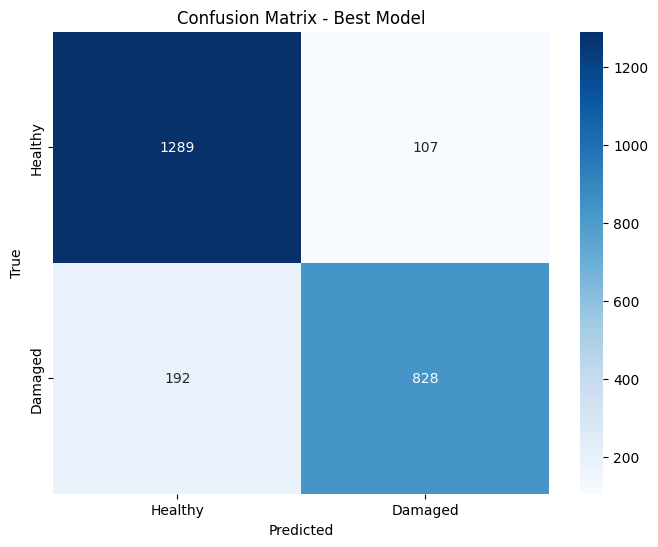

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.87      0.92      0.90      1396
     Damaged       0.89      0.81      0.85      1020

    accuracy                           0.88      2416
   macro avg       0.88      0.87      0.87      2416
weighted avg       0.88      0.88      0.88      2416



In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# True labels for the test set
y_test_true = np.argmax(y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_true, y_test_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Healthy', 'Damaged'], yticklabels=['Healthy', 'Damaged'])
plt.title('Confusion Matrix - Best Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix_best_model.png', dpi=450)  # Save the figure with high DPI
plt.show()

# Classification Report
class_report = classification_report(y_test_true, y_test_pred, target_names=['Healthy', 'Damaged'])

# Print the classification report
print("Classification Report:")
print(class_report)

# Optionally, save the classification report to a file
with open('classification_report_best_model.txt', 'w') as f:
    f.write(class_report)

In [7]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import csv

# Save metrics to Excel (CSV in this case)
def save_metrics_to_excel(writer, model_name, phase, y_true, y_pred, y_probs):
    # Convert one-hot encoded true labels to 1D array if necessary
    if len(y_true.shape) > 1:  # Check if y_true is 2D (one-hot encoded)
        y_true = np.argmax(y_true, axis=1)
    
    # Ensure y_probs is correctly indexed (if y_probs is 1D, skip the indexing)
    if len(y_probs.shape) > 1:  # Check if y_probs has multiple columns (for multiple classes)
        y_probs = y_probs[:, 1]  # Use the probabilities for the positive class (class 1)

    # Calculate metrics
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    auroc = roc_auc_score(y_true, y_probs)  # Pass true labels and positive class probabilities
    auprc = average_precision_score(y_true, y_probs)
    accuracy = np.mean(y_true == y_pred)

    # Write the metrics to the CSV file
    writer.writerow([model_name, phase, f1, accuracy, precision, recall, auroc, auprc])


# Save all metrics for both train and test sets
def save_all_metrics(models, history, y_train_true, y_train_pred, y_test_true, y_test_pred, y_train_probs, y_test_probs):
    with open('model_metrics.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Model', 'Phase', 'F1', 'Accuracy', 'Precision', 'Recall', 'AUROC', 'AUPRC'])

        # Metrics for train and test phases
        for model_name in models.keys():
            # Train metrics
            save_metrics_to_excel(
                writer, model_name, 'Train', y_train_true, y_train_pred[model_name], y_train_probs[model_name]
            )
            # Test metrics
            save_metrics_to_excel(
                writer, model_name, 'Test', y_test_true, y_test_pred[model_name], y_test_probs[model_name]
            )


In [8]:
# Ablation study configuration
ablation_configs = [
    {'name': 'Best Model (Optuna)', 'no_residual_blocks': False, 'no_attention': False, 'no_dropout': False, 'no_kernel_size_variation': False, 'no_batchnorm': False},
    {'name': 'Baseline', 'no_residual_blocks': False, 'no_attention': False, 'no_dropout': False, 'no_kernel_size_variation': False, 'no_batchnorm': False},
    {'name': 'No Residual Blocks', 'no_residual_blocks': True, 'no_attention': False, 'no_dropout': False, 'no_kernel_size_variation': False, 'no_batchnorm': False},
    {'name': 'No Attention Blocks', 'no_residual_blocks': False, 'no_attention': True, 'no_dropout': False, 'no_kernel_size_variation': False, 'no_batchnorm': False},
    {'name': 'No Dropout', 'no_residual_blocks': False, 'no_attention': False, 'no_dropout': True, 'no_kernel_size_variation': False, 'no_batchnorm': False},
    {'name': 'Fixed Kernel Size', 'no_residual_blocks': False, 'no_attention': False, 'no_dropout': False, 'no_kernel_size_variation': True, 'no_batchnorm': False},
    {'name': 'No Batch Normalization', 'no_residual_blocks': False, 'no_attention': False, 'no_dropout': False, 'no_kernel_size_variation': False, 'no_batchnorm': True},
]

# Function to build ablation models
def build_ablation_model(ablation_config, best_params):
    num_residual_blocks = best_params['num_residual_blocks'] if not ablation_config.get('no_residual_blocks') else 0
    filters = best_params['filters']
    kernel_size = best_params['kernel_size'] if not ablation_config.get('no_kernel_size_variation') else 3
    dense_units = best_params['dense_units']
    dropout_rate = best_params['dropout_rate'] if not ablation_config.get('no_dropout') else 0.0
    learning_rate = best_params['learning_rate']
    
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    for _ in range(num_residual_blocks):
        x = residual_block(x, filters, kernel_size, use_batchnorm=not ablation_config.get('no_batchnorm'))
        if not ablation_config.get('no_attention'):
            x = attention_block(x, filters)
        if x.shape[1] >= 2 and x.shape[2] >= 2:
            x = MaxPooling2D((2, 2))(x)
    
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(dense_units, activation='relu')(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)
    outputs = Dense(2, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to gather performance metrics for ablation models
# Function to gather performance metrics for ablation models
def ablation_study(best_params, ablation_configs):
    ablation_results = []
    models = {}
    train_probs = {}
    test_probs = {}

    for config in ablation_configs:
        config_name = config['name']  # Ensure config name is consistent
        print(f"Training Ablation Model: {config_name}")
        ablation_model = build_ablation_model(config, best_params)

        # Train the ablation model
        history = ablation_model.fit(
            train_generator,
            steps_per_epoch=len(X_train) // BATCH_SIZE,
            epochs=200,
            validation_data=val_generator,
            class_weight=class_weights,
            verbose=1
        )
        
        # Save the current ablation model
        ablation_model.save(f'ablation_model_{config["name"]}.h5')  # Save each model with its configuration name


        # Predict on train and test sets
        y_train_pred_ablation = np.argmax(ablation_model.predict(X_train, batch_size=BATCH_SIZE), axis=1)
        steps = np.ceil(len(X_test) / BATCH_SIZE).astype(int)
        y_test_pred_ablation = np.argmax(ablation_model.predict(X_test, batch_size=BATCH_SIZE, steps=steps), axis=1)

        # Predict probabilities
        y_test_probs_ablation = ablation_model.predict(X_test, batch_size=BATCH_SIZE, steps=steps)

        # Ensure y_test_probs matches y_test_true length
        y_test_probs_ablation = y_test_probs_ablation[:len(y_test_true)]

        # Add predictions and probabilities to dictionaries
        models[config_name] = y_train_pred_ablation
        train_probs[config_name] = ablation_model.predict(X_train, batch_size=BATCH_SIZE)
        test_probs[config_name] = y_test_probs_ablation

        # Collect test metrics
        test_loss, test_accuracy = ablation_model.evaluate(X_test, y_test, verbose=0)
        precision = precision_score(np.argmax(y_test, axis=1), y_test_pred_ablation, average='weighted')
        recall = recall_score(np.argmax(y_test, axis=1), y_test_pred_ablation, average='weighted')
        f1 = f1_score(np.argmax(y_test, axis=1), y_test_pred_ablation, average='weighted')

        ablation_results.append({
            'Configuration': config_name,
            'Test Accuracy': test_accuracy,
            'Test Loss': test_loss,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

        # Plot and save confusion matrix
        conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_test_pred_ablation)
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.title(f'Confusion Matrix - {config["name"]}')
        plt.savefig(f'confusion_matrix_{config["name"]}.png', dpi=450)
        plt.show()

        # Plot and save loss curve
        plt.plot(history.history['loss'], label=f'{config["name"]} - Train Loss')
        plt.plot(history.history['val_loss'], label=f'{config["name"]} - Val Loss')
        plt.title(f'Loss Comparison - {config["name"]}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(f'loss_comparison_{config["name"]}.png', dpi=450)
        plt.show()

    # Save ablation metrics to Excel
    ablation_results_df = pd.DataFrame(ablation_results)
    ablation_results_df.to_excel('ablation_study_results.xlsx', index=False)

    # **Call save_all_metrics** after all ablation models have been evaluated
    # Save all metrics
    save_all_metrics(
        models,
        history,  # You can use any model's history since we are not saving it in the file
        np.argmax(y_train, axis=1),  # True train labels
        models,  # Train predictions for each ablation config
        np.argmax(y_test, axis=1),  # True test labels
        {config['name']: np.argmax(y_test, axis=1) for config in ablation_configs},  # Test predictions
        train_probs,  # Train probabilities for AUROC and AUPRC
        test_probs  # Test probabilities for AUROC and AUPRC
    )

    return ablation_results_df, models, train_probs, test_probs


Training Ablation Model: Best Model (Optuna)
Epoch 1/200
226/226 [==============================] - 56s 234ms/step - loss: 0.7541 - accuracy: 0.5256 - val_loss: 0.6907 - val_accuracy: 0.5778
Epoch 2/200
226/226 [==============================] - 53s 233ms/step - loss: 0.6990 - accuracy: 0.5431 - val_loss: 0.6876 - val_accuracy: 0.5778
Epoch 3/200
226/226 [==============================] - 53s 234ms/step - loss: 0.6830 - accuracy: 0.5607 - val_loss: 0.6902 - val_accuracy: 0.5356
Epoch 4/200
226/226 [==============================] - 53s 234ms/step - loss: 0.6814 - accuracy: 0.5714 - val_loss: 0.7115 - val_accuracy: 0.5766
Epoch 5/200
226/226 [==============================] - 53s 234ms/step - loss: 0.6760 - accuracy: 0.5847 - val_loss: 0.6821 - val_accuracy: 0.5550
Epoch 6/200
226/226 [==============================] - 53s 234ms/step - loss: 0.6785 - accuracy: 0.5650 - val_loss: 0.7347 - val_accuracy: 0.4541
Epoch 7/200
226/226 [==============================] - 53s 234ms/step - loss: 0

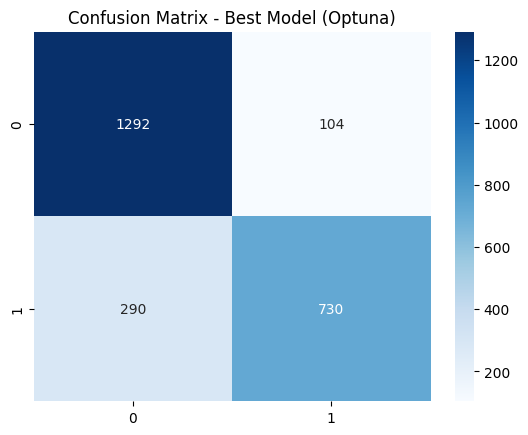

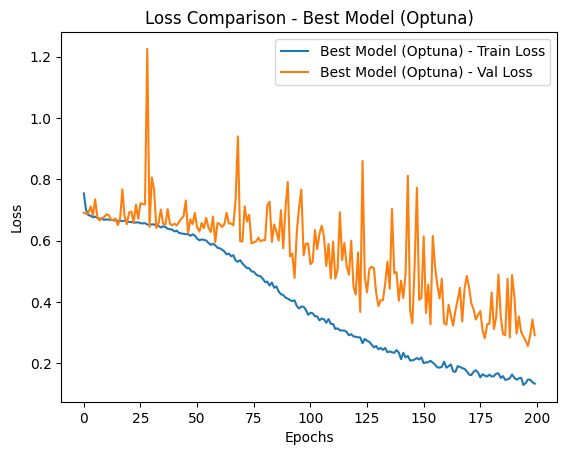

Training Ablation Model: Baseline
Epoch 1/200
226/226 [==============================] - 56s 236ms/step - loss: 0.7603 - accuracy: 0.5158 - val_loss: 0.6937 - val_accuracy: 0.4201
Epoch 2/200
226/226 [==============================] - 53s 234ms/step - loss: 0.6997 - accuracy: 0.5478 - val_loss: 0.6918 - val_accuracy: 0.5778
Epoch 3/200
226/226 [==============================] - 53s 235ms/step - loss: 0.6854 - accuracy: 0.5653 - val_loss: 0.6907 - val_accuracy: 0.5265
Epoch 4/200
226/226 [==============================] - 53s 235ms/step - loss: 0.6796 - accuracy: 0.5764 - val_loss: 0.6660 - val_accuracy: 0.5948
Epoch 5/200
226/226 [==============================] - 53s 235ms/step - loss: 0.6770 - accuracy: 0.5862 - val_loss: 0.7553 - val_accuracy: 0.4946
Epoch 6/200
226/226 [==============================] - 53s 235ms/step - loss: 0.6745 - accuracy: 0.5917 - val_loss: 0.7522 - val_accuracy: 0.5451
Epoch 7/200
226/226 [==============================] - 53s 235ms/step - loss: 0.6742 - acc

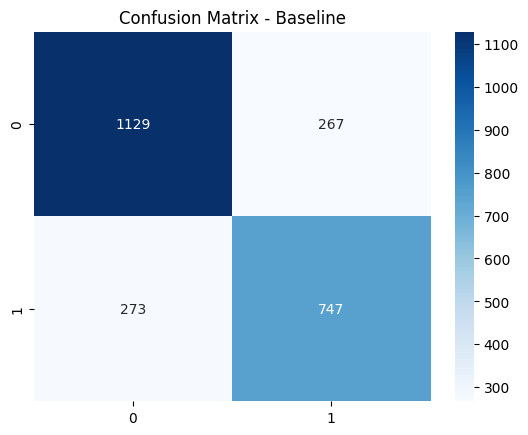

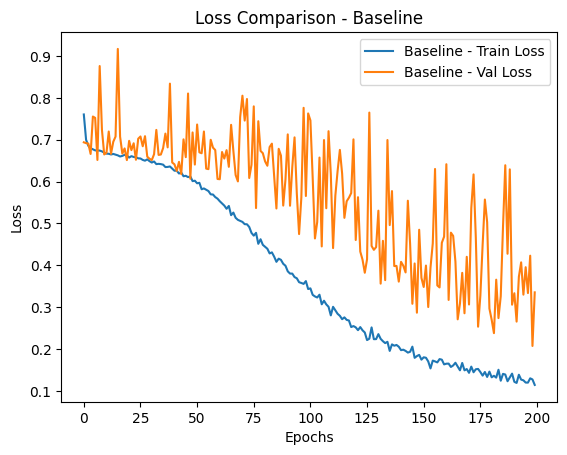

Training Ablation Model: No Residual Blocks
Epoch 1/200
226/226 [==============================] - 11s 48ms/step - loss: 0.6939 - accuracy: 0.4884 - val_loss: 0.6913 - val_accuracy: 0.5890
Epoch 2/200
226/226 [==============================] - 10s 42ms/step - loss: 0.6930 - accuracy: 0.4935 - val_loss: 0.6903 - val_accuracy: 0.5944
Epoch 3/200
226/226 [==============================] - 8s 37ms/step - loss: 0.6918 - accuracy: 0.5188 - val_loss: 0.6898 - val_accuracy: 0.5522
Epoch 4/200
226/226 [==============================] - 8s 37ms/step - loss: 0.6913 - accuracy: 0.5256 - val_loss: 0.6949 - val_accuracy: 0.4810
Epoch 5/200
226/226 [==============================] - 8s 37ms/step - loss: 0.6897 - accuracy: 0.5382 - val_loss: 0.6918 - val_accuracy: 0.5170
Epoch 6/200
226/226 [==============================] - 8s 38ms/step - loss: 0.6884 - accuracy: 0.5428 - val_loss: 0.6947 - val_accuracy: 0.5029
Epoch 7/200
226/226 [==============================] - 8s 37ms/step - loss: 0.6865 - accur

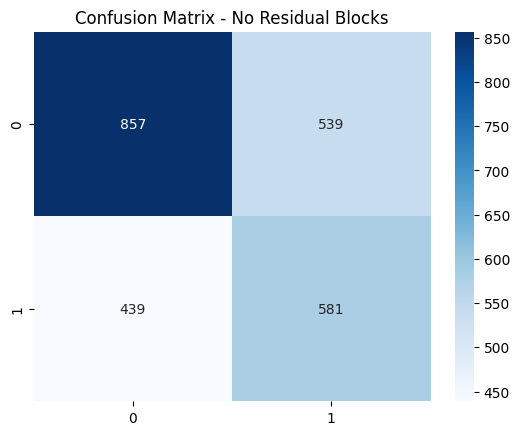

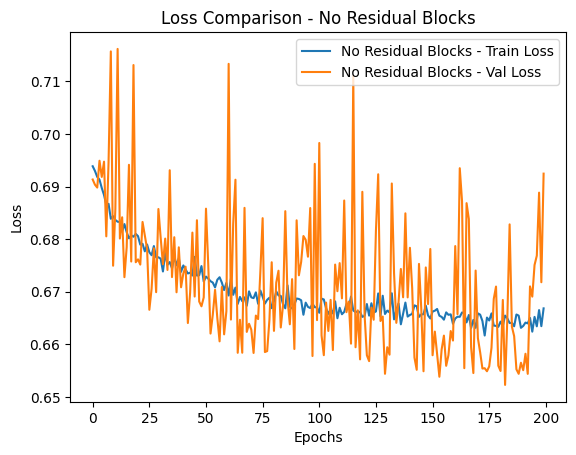

Training Ablation Model: No Attention Blocks
Epoch 1/200
226/226 [==============================] - 10s 38ms/step - loss: 0.8134 - accuracy: 0.5122 - val_loss: 0.6902 - val_accuracy: 0.5778
Epoch 2/200
226/226 [==============================] - 9s 38ms/step - loss: 0.7084 - accuracy: 0.5486 - val_loss: 0.6977 - val_accuracy: 0.4222
Epoch 3/200
226/226 [==============================] - 8s 37ms/step - loss: 0.6895 - accuracy: 0.5689 - val_loss: 0.7107 - val_accuracy: 0.4222
Epoch 4/200
226/226 [==============================] - 9s 38ms/step - loss: 0.6847 - accuracy: 0.5658 - val_loss: 0.7680 - val_accuracy: 0.5778
Epoch 5/200
226/226 [==============================] - 8s 37ms/step - loss: 0.6792 - accuracy: 0.5687 - val_loss: 0.6752 - val_accuracy: 0.5869
Epoch 6/200
226/226 [==============================] - 9s 38ms/step - loss: 0.6743 - accuracy: 0.5837 - val_loss: 0.6868 - val_accuracy: 0.5778
Epoch 7/200
226/226 [==============================] - 9s 38ms/step - loss: 0.6741 - accur

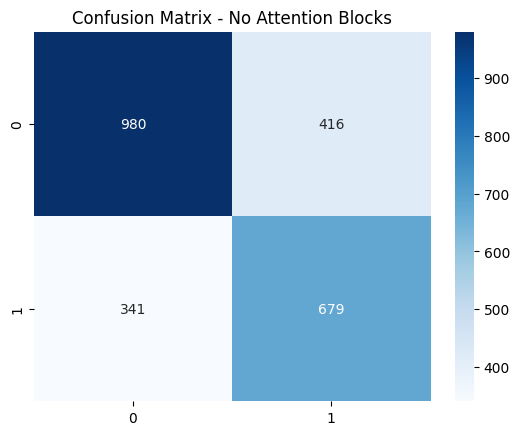

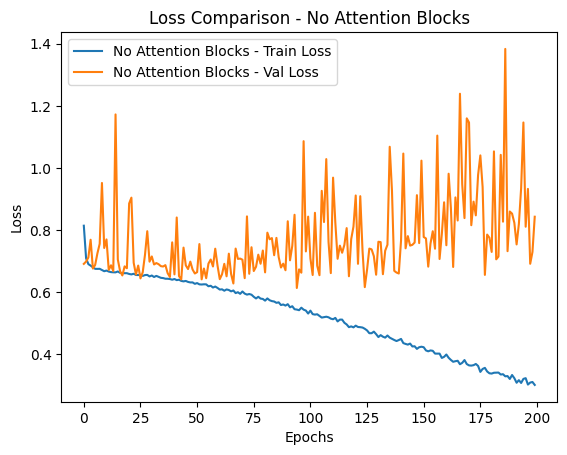

Training Ablation Model: No Dropout
Epoch 1/200
226/226 [==============================] - 55s 232ms/step - loss: 0.7201 - accuracy: 0.5272 - val_loss: 0.6942 - val_accuracy: 0.4222
Epoch 2/200
226/226 [==============================] - 52s 232ms/step - loss: 0.6918 - accuracy: 0.5467 - val_loss: 0.6939 - val_accuracy: 0.4243
Epoch 3/200
226/226 [==============================] - 53s 233ms/step - loss: 0.6841 - accuracy: 0.5628 - val_loss: 0.6761 - val_accuracy: 0.5778
Epoch 4/200
226/226 [==============================] - 53s 234ms/step - loss: 0.6778 - accuracy: 0.5820 - val_loss: 0.6699 - val_accuracy: 0.5890
Epoch 5/200
226/226 [==============================] - 53s 234ms/step - loss: 0.6750 - accuracy: 0.5847 - val_loss: 0.8999 - val_accuracy: 0.4334
Epoch 6/200
226/226 [==============================] - 53s 234ms/step - loss: 0.6763 - accuracy: 0.5809 - val_loss: 0.6820 - val_accuracy: 0.6076
Epoch 7/200
226/226 [==============================] - 53s 234ms/step - loss: 0.6710 - a

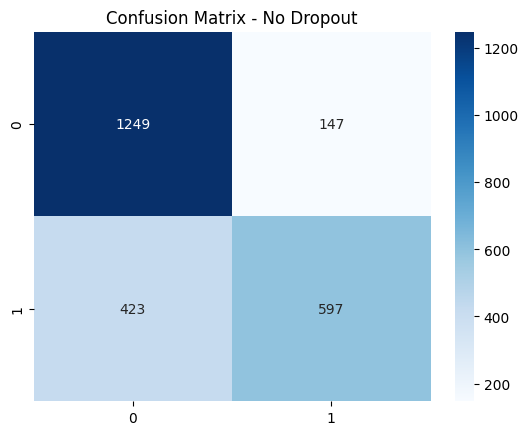

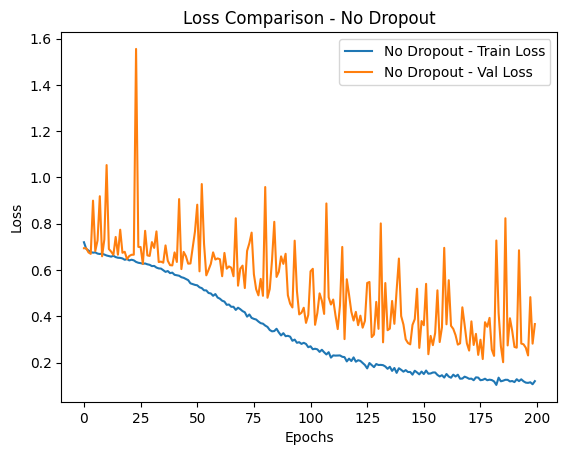

Training Ablation Model: Fixed Kernel Size
Epoch 1/200
226/226 [==============================] - 56s 235ms/step - loss: 0.7791 - accuracy: 0.5134 - val_loss: 0.6890 - val_accuracy: 0.5778
Epoch 2/200
226/226 [==============================] - 53s 233ms/step - loss: 0.6995 - accuracy: 0.5463 - val_loss: 0.6985 - val_accuracy: 0.4222
Epoch 3/200
226/226 [==============================] - 53s 233ms/step - loss: 0.6850 - accuracy: 0.5599 - val_loss: 0.7127 - val_accuracy: 0.4222
Epoch 4/200
226/226 [==============================] - 53s 233ms/step - loss: 0.6769 - accuracy: 0.5761 - val_loss: 0.6784 - val_accuracy: 0.5766
Epoch 5/200
226/226 [==============================] - 53s 233ms/step - loss: 0.6742 - accuracy: 0.5880 - val_loss: 0.7249 - val_accuracy: 0.4925
Epoch 6/200
226/226 [==============================] - 53s 233ms/step - loss: 0.6717 - accuracy: 0.5947 - val_loss: 0.6754 - val_accuracy: 0.5923
Epoch 7/200
226/226 [==============================] - 53s 233ms/step - loss: 0.6

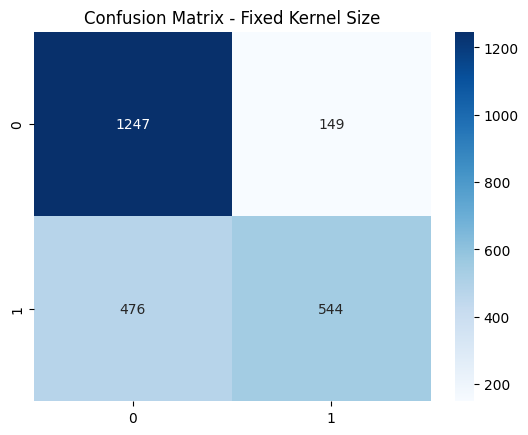

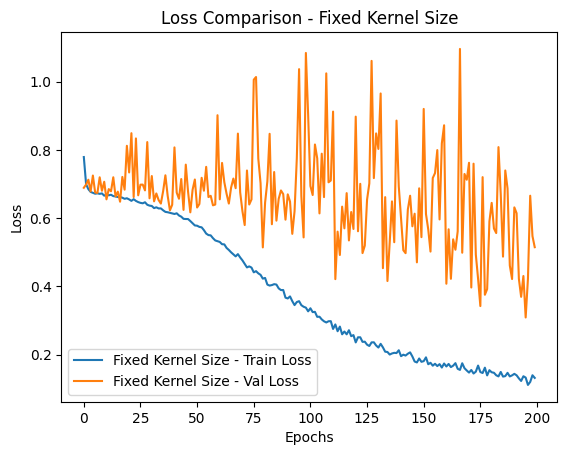

Training Ablation Model: No Batch Normalization
Epoch 1/200
226/226 [==============================] - 55s 232ms/step - loss: 0.6950 - accuracy: 0.4978 - val_loss: 0.6959 - val_accuracy: 0.4222
Epoch 2/200
226/226 [==============================] - 52s 230ms/step - loss: 0.6939 - accuracy: 0.5001 - val_loss: 0.6849 - val_accuracy: 0.5778
Epoch 3/200
226/226 [==============================] - 52s 230ms/step - loss: 0.6935 - accuracy: 0.5132 - val_loss: 0.6914 - val_accuracy: 0.5832
Epoch 4/200
226/226 [==============================] - 52s 230ms/step - loss: 0.6917 - accuracy: 0.5353 - val_loss: 0.7098 - val_accuracy: 0.4238
Epoch 5/200
226/226 [==============================] - 52s 230ms/step - loss: 0.6929 - accuracy: 0.5161 - val_loss: 0.7029 - val_accuracy: 0.4197
Epoch 6/200
226/226 [==============================] - 52s 229ms/step - loss: 0.6914 - accuracy: 0.5288 - val_loss: 0.7095 - val_accuracy: 0.4214
Epoch 7/200
226/226 [==============================] - 52s 230ms/step - loss

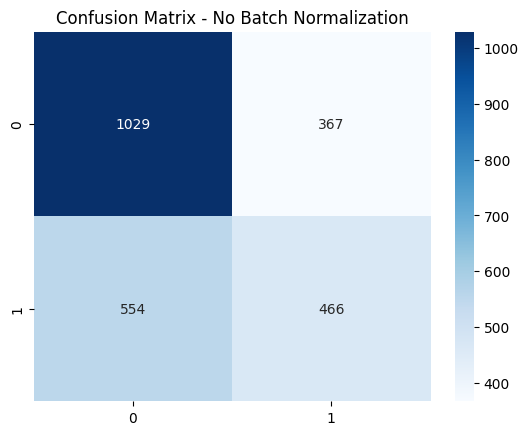

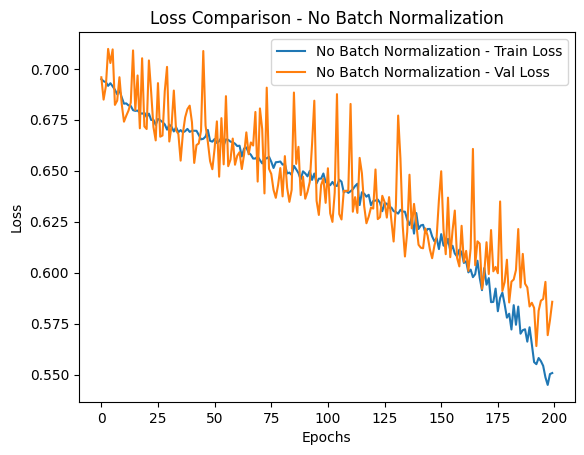

Full study results (including ablation) saved to 'full_study_results.xlsx'.


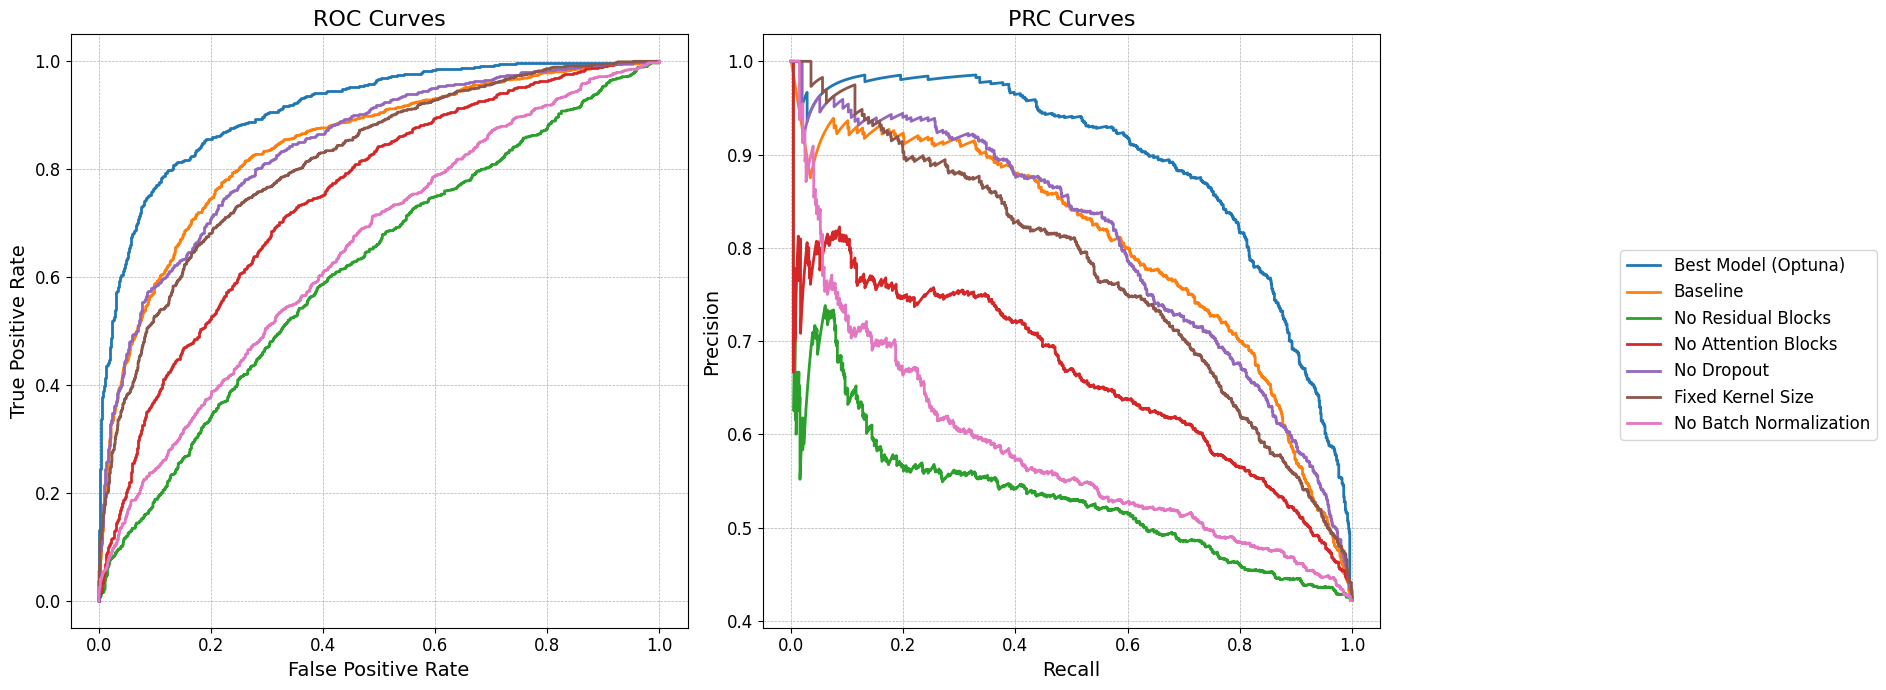

In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc, precision_recall_curve, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Perform the ablation study (assuming ablation_study is defined elsewhere)
ablation_results_df, models, train_probs, test_probs = ablation_study(best_params, ablation_configs)

# Combine and save full results, including Optuna best model
optuna_best_results = {
    'Configuration': 'Best Model (Optuna)',
    'Test Accuracy': np.max(history.history['val_accuracy']),
    'Test Loss': np.min(history.history['val_loss']),
    'Precision': precision_score(y_test_true, y_test_pred, average='weighted'),
    'Recall': recall_score(y_test_true, y_test_pred, average='weighted'),
    'F1 Score': f1_score(y_test_true, y_test_pred, average='weighted')
}

# Convert Optuna best results to a DataFrame and concatenate with ablation results
optuna_best_results_df = pd.DataFrame([optuna_best_results])
final_results = pd.concat([ablation_results_df, optuna_best_results_df], ignore_index=True)

# Save the full study results to Excel
final_results.to_excel('full_study_results.xlsx', index=False)
print("Full study results (including ablation) saved to 'full_study_results.xlsx'.")

# Function to generate ROC & PRC curves for each configuration
def generate_roc_prc_for_configs(models, y_test_true, y_test_probs):
    roc_curves = []
    prc_curves = []
    config_names = []
    
    # Loop over each model and its predictions
    for config_name, y_probs in test_probs.items():
        # Ensure y_probs has two columns (for positive class probabilities)
        fpr, tpr, _ = roc_curve(y_test_true, y_probs[:, 1])  # Positive class probabilities
        roc_curves.append((fpr, tpr))

        precision, recall, _ = precision_recall_curve(y_test_true, y_probs[:, 1])
        prc_curves.append((recall, precision))

        config_names.append(config_name)

    return roc_curves, prc_curves, config_names

# Create overlapping ROC & PRC plots for ablation configurations
def save_roc_prc_plots(roc_curves, prc_curves, config_names):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

    # Increase line width for better visibility
    for name, roc_curve, prc_curve in zip(config_names, roc_curves, prc_curves):
        ax1.plot(roc_curve[0], roc_curve[1], label=name, linewidth=2)
        ax2.plot(prc_curve[0], prc_curve[1], label=name, linewidth=2)

    ax1.set_title('ROC Curves', fontsize=16)
    ax2.set_title('PRC Curves', fontsize=16)
    ax1.set_xlabel('False Positive Rate', fontsize=14)
    ax2.set_xlabel('Recall', fontsize=14)
    ax1.set_ylabel('True Positive Rate', fontsize=14)
    ax2.set_ylabel('Precision', fontsize=14)

    # Add gridlines for better readability
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Increase the size of ticks
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax2.tick_params(axis='both', which='major', labelsize=12)

    # Adjust the legend to be more readable
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.35, 0.5), fontsize=12)

    plt.tight_layout()  # Adjust spacing between subplots
    plt.savefig('roc_prc_combined_enhanced.png', dpi=450, bbox_inches='tight')
    plt.show()


# Example of calling the generate_roc_prc_for_configs function after generating curves for each configuration
# Assuming you have y_test_true and y_test_probs ready for each configuration


# Assuming y_test_true is the true labels for the test set
roc_curves, prc_curves, config_names = generate_roc_prc_for_configs(models, np.argmax(y_test, axis=1), test_probs)

# Call the function to save the overlapping ROC & PRC plots
save_roc_prc_plots(roc_curves, prc_curves, config_names)